# Imports and Pre-requisites

In [2]:
import geemap
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import optimize
# %matplotlib inline

# from datetime import timedelta, datetime


In [3]:
import ee
import matplotlib.pyplot as plt
import pandas as pd

# from src.geometry import districts, rwanda, rwanda_buffered
from src.fetch_datasets import fetch_all

chirps, era5_temp, soil_moist, ndvi, dem, slope = fetch_all()

In [4]:
try:
    ee.Authenticate()
except Exception as e:
    print(f"Error authenticating Earth Engine: {e}. Please ensure you have Earth Engine access.")

In [5]:
try:
    ee.Initialize(project="rwanda-climate-alerts")
except Exception as e:
    print(f"Error initializing Earth Engine: {e}. Please ensure you are authenticated.")

# Collect Datasets

In [18]:
from src.geometry import districts, rwanda, rwanda_buffered

# Create map
Map = geemap.Map()
Map.centerObject(districts, 7)


In [19]:
chirps, era5_temp, soil_moist, ndvi, dem, slope = fetch_all()

dataset_dict = {
    "chirps": {
        "dataset": chirps,
        "list of bands": ["precipitation"],
        "title": "Precipitation in ",
        "xlabel": "Date",
        "ylabel": "Precipitation [mm]",
        "ylim_min": -0,
        "ylim_max": 100
    },
    "era5_temp": {
        "dataset": era5_temp,
        "list of bands": ["temperature_2m"],
        "title": "Temperature in ",
        "xlabel": "Date",
        "ylabel": "Temperature [C]",
        "ylim_min": 10,
        "ylim_max": 30
    },
    "soil_moist": {
        "dataset": era5_temp,
        "list of bands": ["volumetric_soil_water_layer_1"],
        "title": "Soil moisture in ",
        "xlabel": "Date",
        "ylabel": "Moisture [?]",
        "ylim_min": -0,
        "ylim_max": 100
    },
    "ndvi": {
        "dataset": ndvi,
        "list of bands": ["NDVI"],
        "title": "NDVI in ",
        "xlabel": "Date",
        "ylabel": "NDVI [?]",
        "ylim_min": -1.5,
        "ylim_max": 1.5
    }
}

# Fetch Time series

In [31]:
# Fetch Time series
def get_time_series(image_collection, district_name, start_date, end_date, scale):
    district = ee.FeatureCollection("FAO/GAUL/2015/level2") \
                    .filter(ee.Filter.eq("ADM0_NAME", "Rwanda")) \
                    .filter(ee.Filter.eq("ADM2_NAME", district_name)) \
                    .geometry()

    district_time_series = image_collection \
                            .filterDate(start_date, end_date) \
                            .getRegion(district, scale=scale) \
                            .getInfo()

    date_range = [start_date, end_date]

    return district_time_series

bugesera_chirps_ts  = get_time_series(chirps, "Bugesera", "2024-01-01", "2024-12-31", 1000)
bugesera_moist_ts  = get_time_series(soil_moist, "Bugesera", "2024-01-01", "2024-12-31", 1000)
bugesera_ndvi_ts  = get_time_series(ndvi, "Bugesera", "2024-01-01", "2024-12-31", 1000)
#
# print(type(bugesera_chirps_ts), bugesera_chirps_ts)
# print(type(bugesera_moist_ts))
# print(type(bugesera_ndvi_ts))

## Convert to pandas DataFrame

In [46]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

bugesera_moist_df = ee_array_to_df(bugesera_chirps_ts, ['precipitation'])
bugesera_moist_df = ee_array_to_df(bugesera_moist_ts, ['volumetric_soil_water_layer_1'])
bugesera_ndvi_df = ee_array_to_df(bugesera_ndvi_ts, ['NDVI'])

print(bugesera_ndvi_df[:10])
print(bugesera_ndvi_df["NDVI"].mean())
print(bugesera_ndvi_df["NDVI"].median())

0           time   datetime  NDVI
0  1704067200000 2024-01-01  3314
1  1705449600000 2024-01-17  4448
2  1706832000000 2024-02-02  3074
3  1708214400000 2024-02-18  3340
4  1709596800000 2024-03-05  2614
5  1710979200000 2024-03-21  3529
6  1712361600000 2024-04-06  2505
7  1713744000000 2024-04-22  4396
8  1715126400000 2024-05-08  3046
9  1716508800000 2024-05-24  2918
5314.320591199194
5523.0


## Plot the temperature

In [ ]:
def chirps_plot():
    fig_2, ax = plt.subplots(figsize=(14, 6))

    ax.scatter(bugesera_df['datetime'], bugesera_df['precipitation'],
               color='black', linewidth=1, alpha=0.7, label='Bugesera (trend)')
               # c='black', alpha=0.2, label='Bugesera (data)')

    import matplotlib.dates as mdates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g., "Jun 2025"
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # bugesera_df['rolling'] = bugesera_df['precipitation'].rolling(window=7).mean()
    # ax.plot(bugesera_df['datetime'], bugesera_df['rolling'],
    #         color='red', linewidth=2, label='7-day average')

    extreme = bugesera_df[bugesera_df['precipitation'] > 60]
    ax.scatter(extreme['datetime'], extreme['precipitation'],
               color='orange', edgecolor='red', s=80, zorder=3, label='Extreme rain')

    ax.set_title('Precipitation in Bugesera', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Precipitation [mm]', fontsize=14)
    ax.set_ylim(-0, 100)
    ax.grid(lw=0.5, ls='--', alpha=0.7)
    ax.legend(fontsize=14, loc='lower right')

chirps_plot()
plt.show()

In [43]:
def t_kelvin_to_celsius(t_kelvin):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  t_kelvin - 273.15
    return t_celsius

## Mock plot function

In [ ]:
import matplotlib.dates as mdates

def plot_dataset(dataframe, title, label, xlabel, ylabel, ylim_min, ylim_max):
    fig, ax_1 = plt.subplots(figsize=(14, 6))

    ax_1.scatter(dataframe['datetime'], dataframe['temperature_2m'],
               color='black', linewidth=1, alpha=0.7, label=label)
               # c='black', alpha=0.2, label='Bugesera (data)')

    ax_1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g., "Jun 2025"
    ax_1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.setp(ax_1.get_xticklabels(), rotation=45, ha="right")

    # extreme = dataframe[dataframe['precipitation'] > 60]
    # ax_1.scatter(extreme['datetime'], extreme['precipitation'],
    #            color='orange', edgecolor='red', s=80, zorder=3, label='Extreme rain')

    ax_1.set_title(title, fontsize=16)
    ax_1.set_xlabel(xlabel, fontsize=14)
    ax_1.set_ylabel(ylabel, fontsize=14)
    ax_1.set_ylim(ylim_min, ylim_max)
    ax_1.grid(lw=0.5, ls='--', alpha=0.7)
    ax_1.legend(fontsize=14, loc='lower right')


In [54]:
def era5_plot():
    fig_2, ax = plt.subplots(figsize=(14, 6))

    ax.scatter(era_5_bugesera_df['datetime'], era_5_bugesera_df['temperature_2m'],
               color='black', linewidth=1, alpha=0.7, label='Bugesera (trend)')
               # c='black', alpha=0.2, label='Bugesera (data)')

    import matplotlib.dates as mdates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g., "Jun 2025"
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # extreme = era_5_bugesera_df[era_5_bugesera_df['precipitation'] > 60]
    # ax.scatter(extreme['datetime'], extreme['precipitation'],
    #            color='orange', edgecolor='red', s=80, zorder=3, label='Extreme rain')

    ax.set_title('Temperature in Bugesera', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Temp [K]', fontsize=14)
    ax.set_ylim(10, 30)
    ax.grid(lw=0.5, ls='--', alpha=0.7)
    ax.legend(fontsize=14, loc='lower right')

era5_temp_time_series = get_time_series(era5_temp, "Bugesera", "2024-01-01", "2024-12-31", 1000)
era_5_bugesera_df = ee_array_to_df(era5_temp_time_series, ['temperature_2m'])
era_5_bugesera_df['temperature_2m'] = era_5_bugesera_df['temperature_2m'] \
                                        .apply(t_kelvin_to_celsius)f

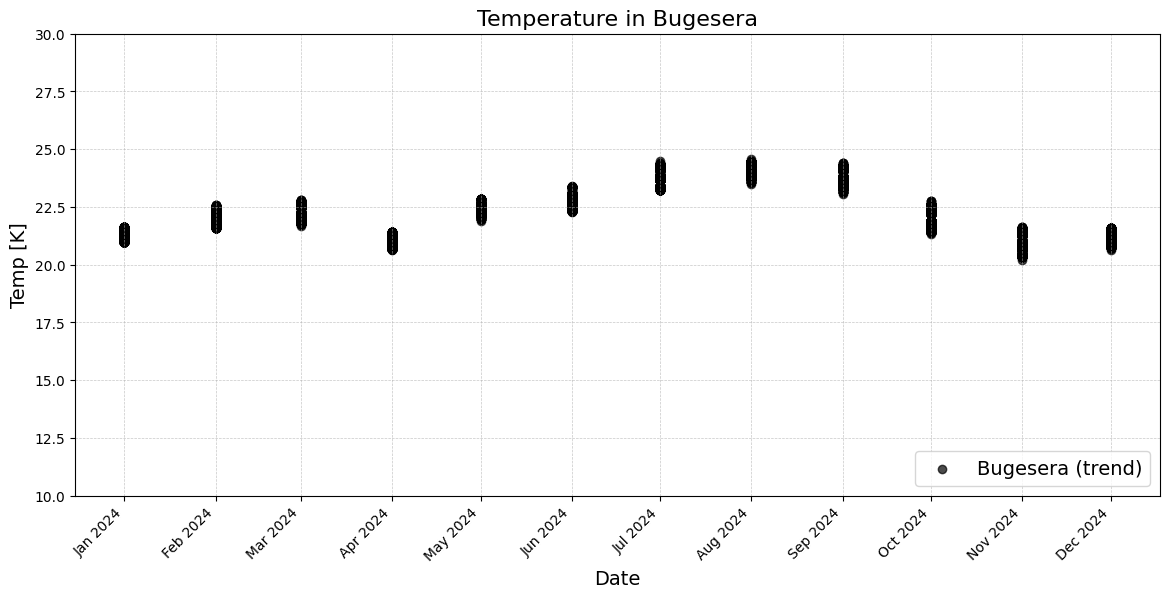

In [52]:
era5_plot()
plt.show()

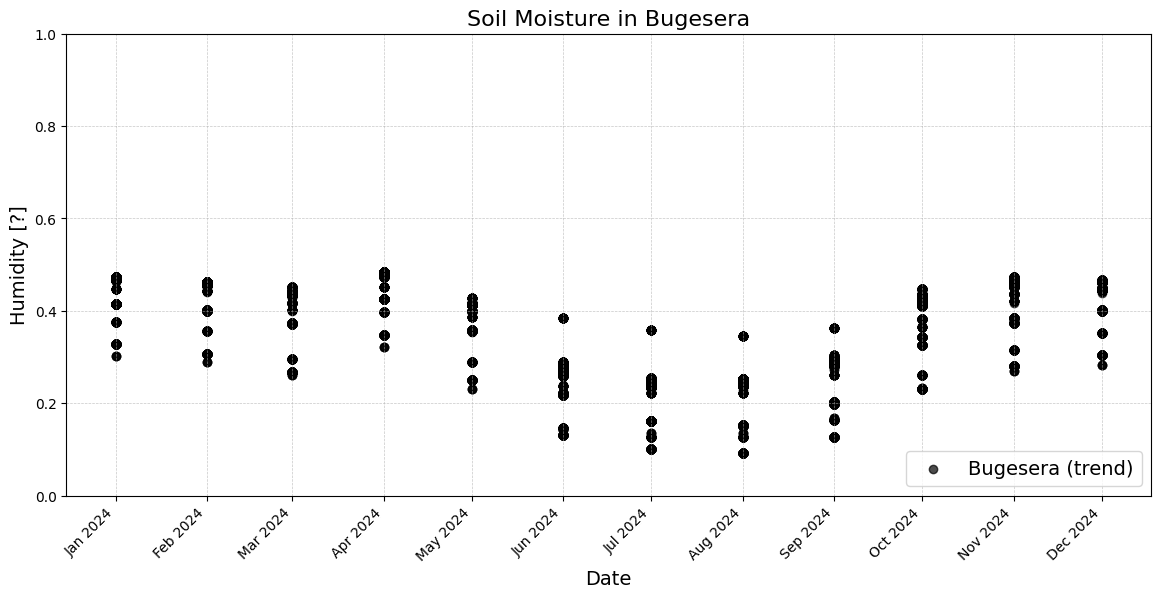

In [37]:
def moist_plot():
    fig_2, ax = plt.subplots(figsize=(14, 6))

    ax.scatter(bugesera_moist_df['datetime'], bugesera_moist_df['volumetric_soil_water_layer_1'],
               color='black', linewidth=1, alpha=0.7, label='Bugesera (trend)')
               # c='black', alpha=0.2, label='Bugesera (data)')

    import matplotlib.dates as mdates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g., "Jun 2025"
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # bugesera_moist_df['rolling'] = bugesera_moist_df['precipitation'].rolling(window=7).mean()
    # ax.plot(bugesera_moist_df['datetime'], bugesera_moist_df['rolling'],
    #         color='red', linewidth=2, label='7-day average')

    # extreme = bugesera_moist_df[bugesera_moist_df['precipitation'] > 60]
    # ax.scatter(extreme['datetime'], extreme['precipitation'],
    #            color='orange', edgecolor='red', s=80, zorder=3, label='Extreme rain')

    ax.set_title('Soil Moisture in Bugesera', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Humidity [?]', fontsize=14)
    ax.set_ylim(-0, 1)
    ax.grid(lw=0.5, ls='--', alpha=0.7)
    ax.legend(fontsize=14, loc='lower right')

moist_plot()
plt.show()

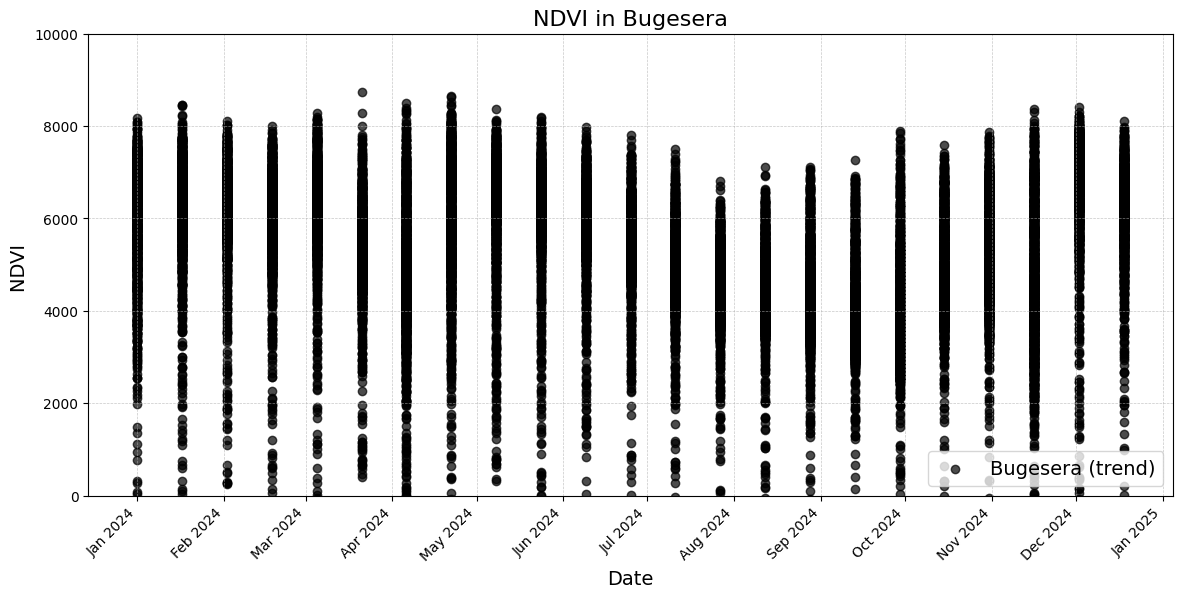

In [48]:
def ndvi_plot():
    fig_2, ax = plt.subplots(figsize=(14, 6))

    ax.scatter(bugesera_ndvi_df['datetime'], bugesera_ndvi_df['NDVI'],
               color='black', linewidth=1, alpha=0.7, label='Bugesera (trend)')
               # c='black', alpha=0.2, label='Bugesera (data)')

    import matplotlib.dates as mdates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g., "Jun 2025"
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # bugesera_moist_df['rolling'] = bugesera_moist_df['precipitation'].rolling(window=7).mean()
    # ax.plot(bugesera_moist_df['datetime'], bugesera_moist_df['rolling'],
    #         color='red', linewidth=2, label='7-day average')

    # extreme = bugesera_moist_df[bugesera_moist_df['precipitation'] > 60]
    # ax.scatter(extreme['datetime'], extreme['precipitation'],
    #            color='orange', edgecolor='red', s=80, zorder=3, label='Extreme rain')

    ax.set_title('NDVI in Bugesera', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('NDVI ', fontsize=14)
    ax.set_ylim(-0, 10000)
    ax.grid(lw=0.5, ls='--', alpha=0.7)
    ax.legend(fontsize=14, loc='lower right')

ndvi_plot()
plt.show()

# Final map

In [ ]:
# vis_params = {"min": 0, "max": 1, "palette": ["green", "yellow", "red"]}
# Map.addLayer(flood_risk_index, vis_params, "Flood Risk Index")
# Map.addLayer(drought_risk_index, vis_params, "Drought Risk Index")
# Map.addLayer(landslide_risk_index, vis_params, "Landslide Risk Index")
#
# # Add district boundaries
# Map.addLayer(districts, {"color": "black"}, "Districts")
#
# Map

## Test functionm

In [ ]:
def make_plot(image_collection, district_name, start_date, end_date, scale):
    time_series, date_range = get_time_series(image_collection, district_name, start_date, end_date, scale)

    final_df = ee_array_to_df(time_series, list_of_bands)

    fig, ax = plot_dataset()

    return fig, ax